In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.8.0+cu128; Torch-cuda version: 12.8; Torch Geometric version: 2.7.0.


In [3]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
DATA_DIR = Data_Path('/home/DSE411/Documents/mlg-music-recommendation/spotify_million_playlist_dataset/data')


with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:
  example_file = json.load(jf)

print(example_file['playlists'][0])

{'name': 'OVO', 'collaborative': 'false', 'pid': 241000, 'modified_at': 1493596800, 'num_tracks': 45, 'num_albums': 10, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Drake', 'track_uri': 'spotify:track:7jslhIiELQkgW9IHeYNOWE', 'artist_uri': 'spotify:artist:3TVXtAsR1Inumwj472S9r4', 'track_name': 'Big Rings', 'album_uri': 'spotify:album:1ozpmkWcCHwsQ4QTnxOOdT', 'duration_ms': 217706, 'album_name': 'What A Time To Be Alive'}, {'pos': 1, 'artist_name': 'Drake', 'track_uri': 'spotify:track:2AGottAzfC8bHzF7kEJ3Wa', 'artist_uri': 'spotify:artist:3TVXtAsR1Inumwj472S9r4', 'track_name': 'Diamonds Dancing', 'album_uri': 'spotify:album:1ozpmkWcCHwsQ4QTnxOOdT', 'duration_ms': 314631, 'album_name': 'What A Time To Be Alive'}, {'pos': 2, 'artist_name': 'Drake', 'track_uri': 'spotify:track:27GmP9AWRs744SzKcpJsTZ', 'artist_uri': 'spotify:artist:3TVXtAsR1Inumwj472S9r4', 'track_name': 'Jumpman', 'album_uri': 'spotify:album:1ozpmkWcCHwsQ4QTnxOOdT', 'duration_ms': 205879, 'album_name': 'What A 

In [5]:
"""
Here we define classes for the data that we are going to load. The data is stored in JSON files, each
which contain playlists, which themselves contain tracks. Thus, we define three classes:
  Track       --> contains information for a specific track (its id, name, etc.)
  Playlist    --> contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile    --> contains the loaded json file and stores a dictionary of all of the Playlists

Note: if we were to use the artist information, we could make an Artist class
"""

class Track:
  """
  Simple class for a track, containing its attributes:
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

class Playlist:
  """
  Simple class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []

  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile:
  """
  Simple class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name


In [6]:
# DATA_PATH = Data_Path('spotify_million_playlist_sample/data')
N_FILES_TO_USE = 50

file_names = sorted(os.listdir(DATA_DIR))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_DIR, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed:   0%|          | 0/50 [00:00<?, ?files/s]

In [7]:
playlist_data = {}
playlists = []
tracks = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs):
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  playlist_data = playlist_data | json_file.playlists

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
## create graph from these lists

# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
edge_list = []
for p_name, playlist in playlist_data.items():
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 507016 . Num edges: 3303932


In [9]:
kcore = 30
G = nx.k_core(G, kcore)
pickle.dump(G, open(f"{kcore}core_first_{N_FILES_TO_USE}.pkl", "wb"))
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


In [10]:
# Make a large subgraph
random.seed(seed)
rand_nodes_lg = random.sample(list(G.nodes()), 2000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())
# Make a smaller subgraph from the larger one
rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)
sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)
largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)
sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))
print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),
      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1868 . Num edges: 5147
Small subgraph Num nodes: 144 . Num edges: 159


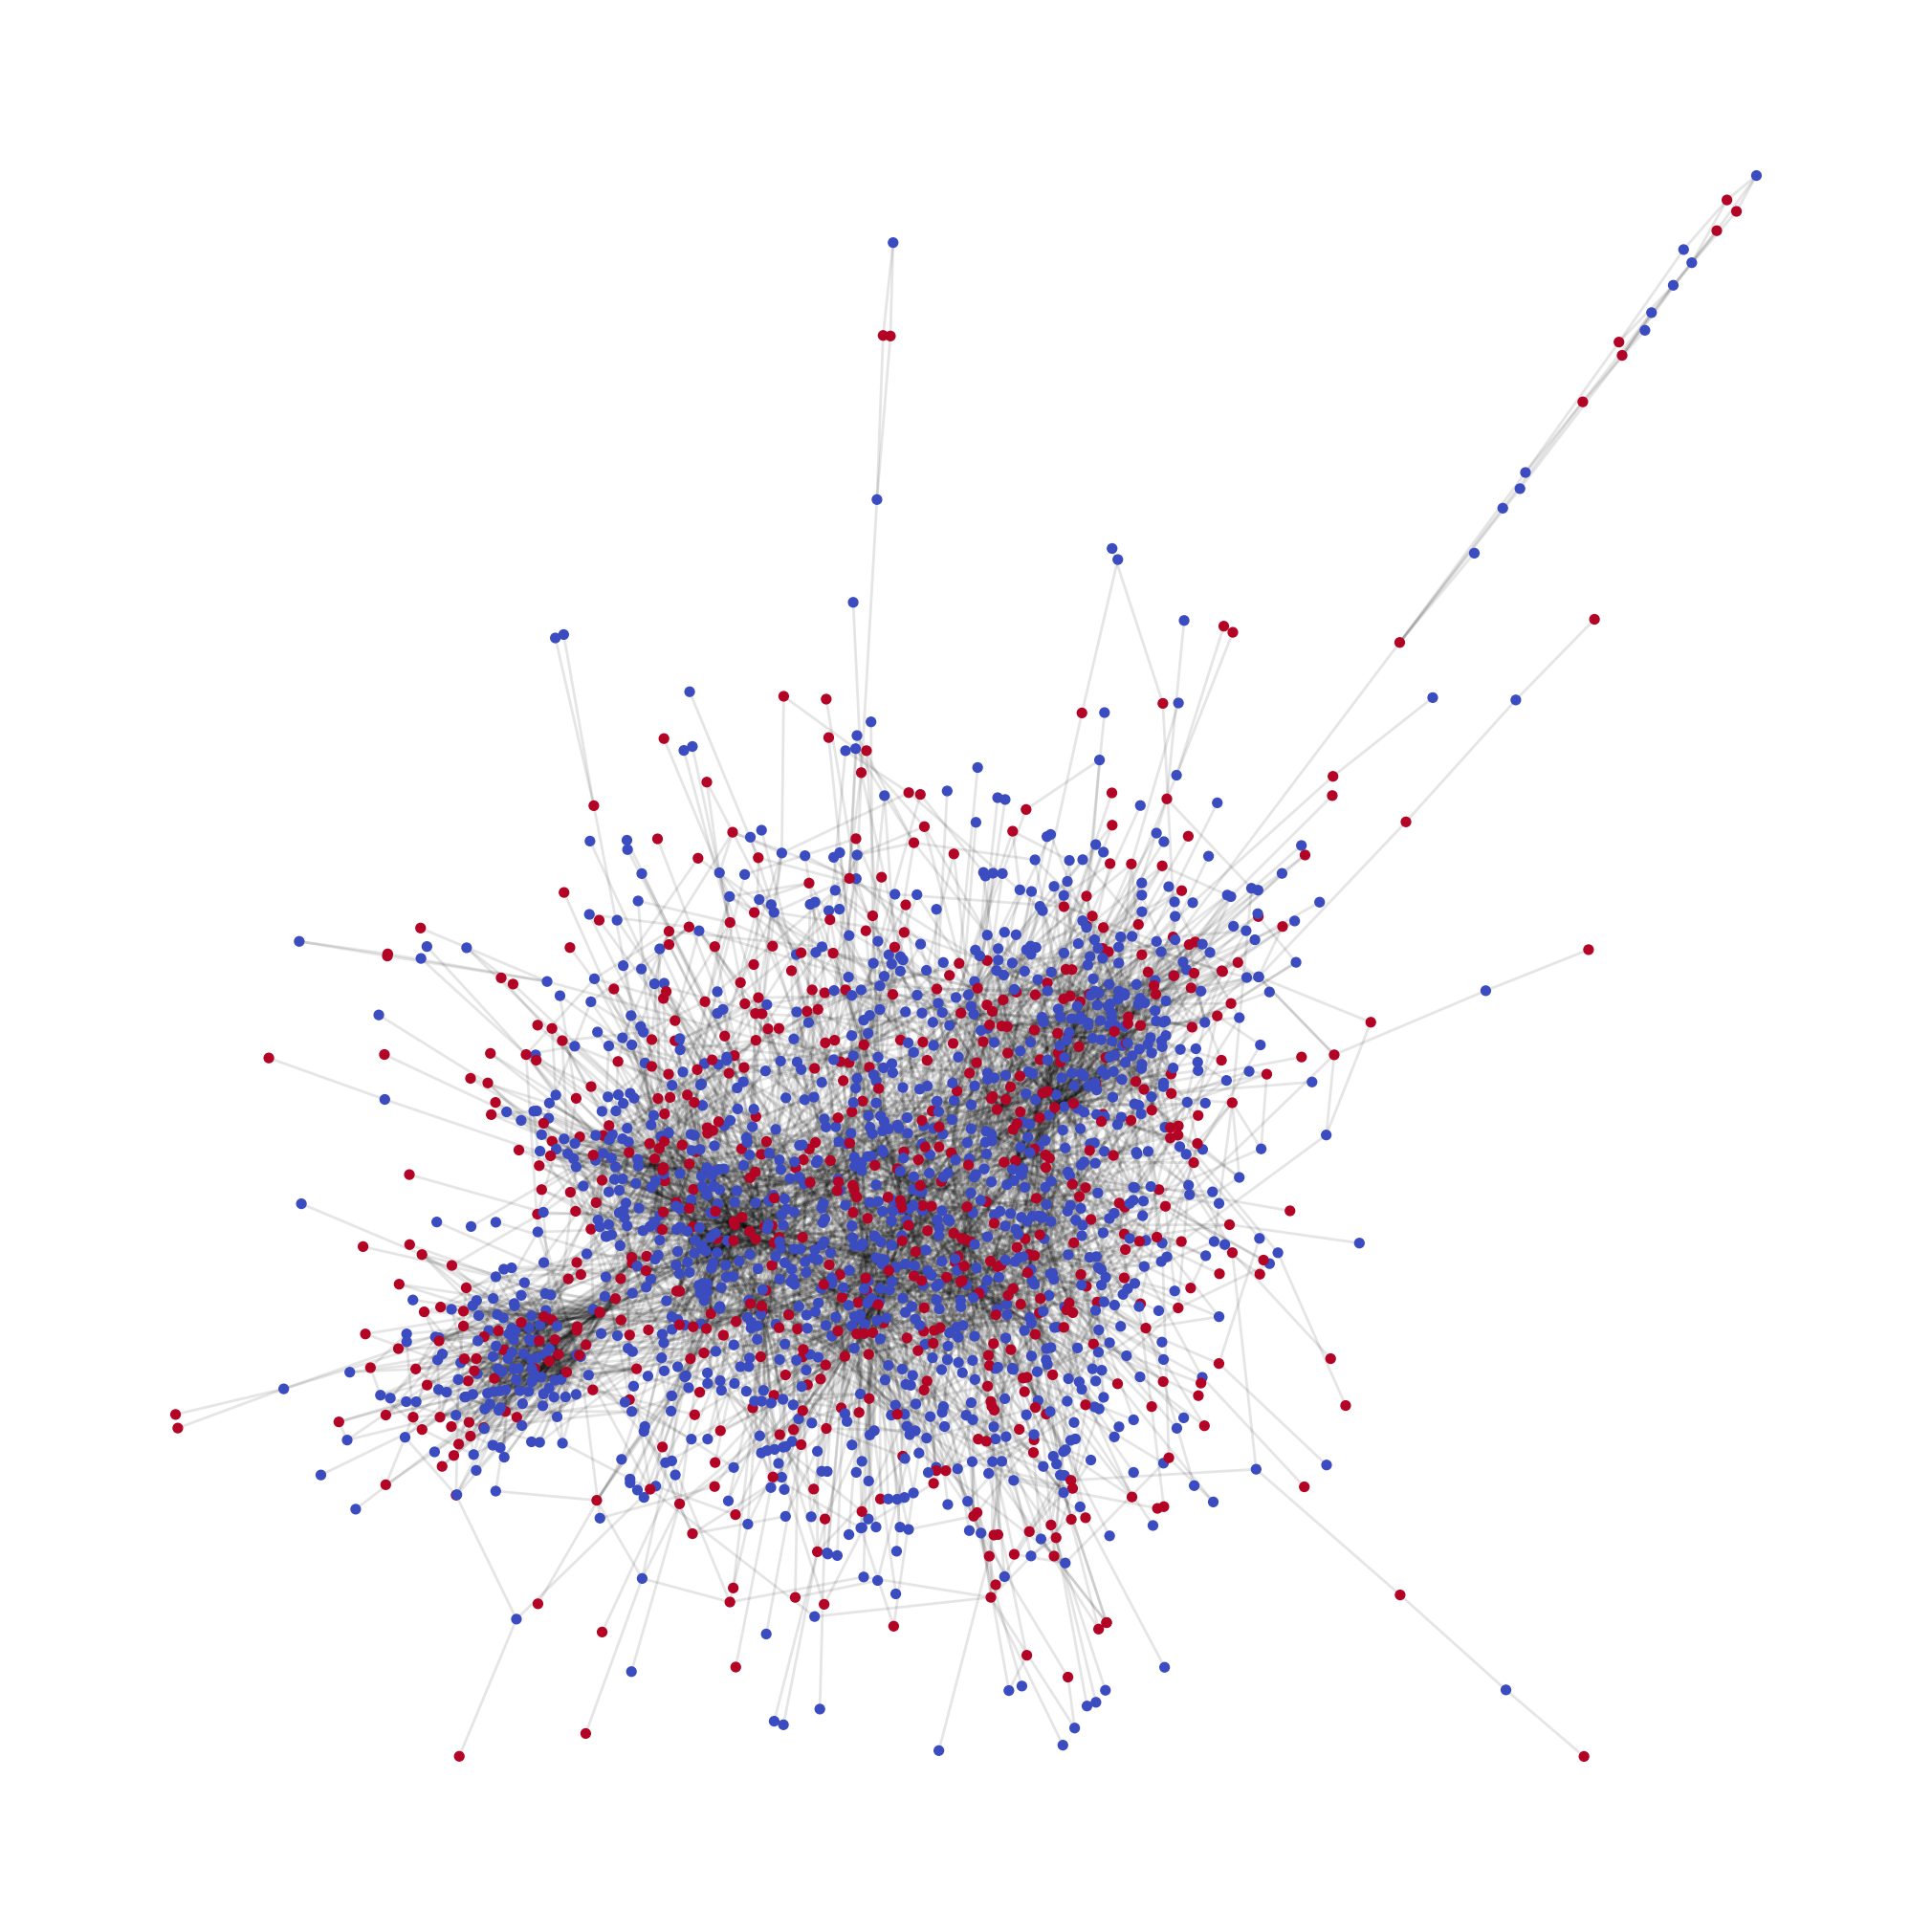

In [11]:
# Graph the large subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]
plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

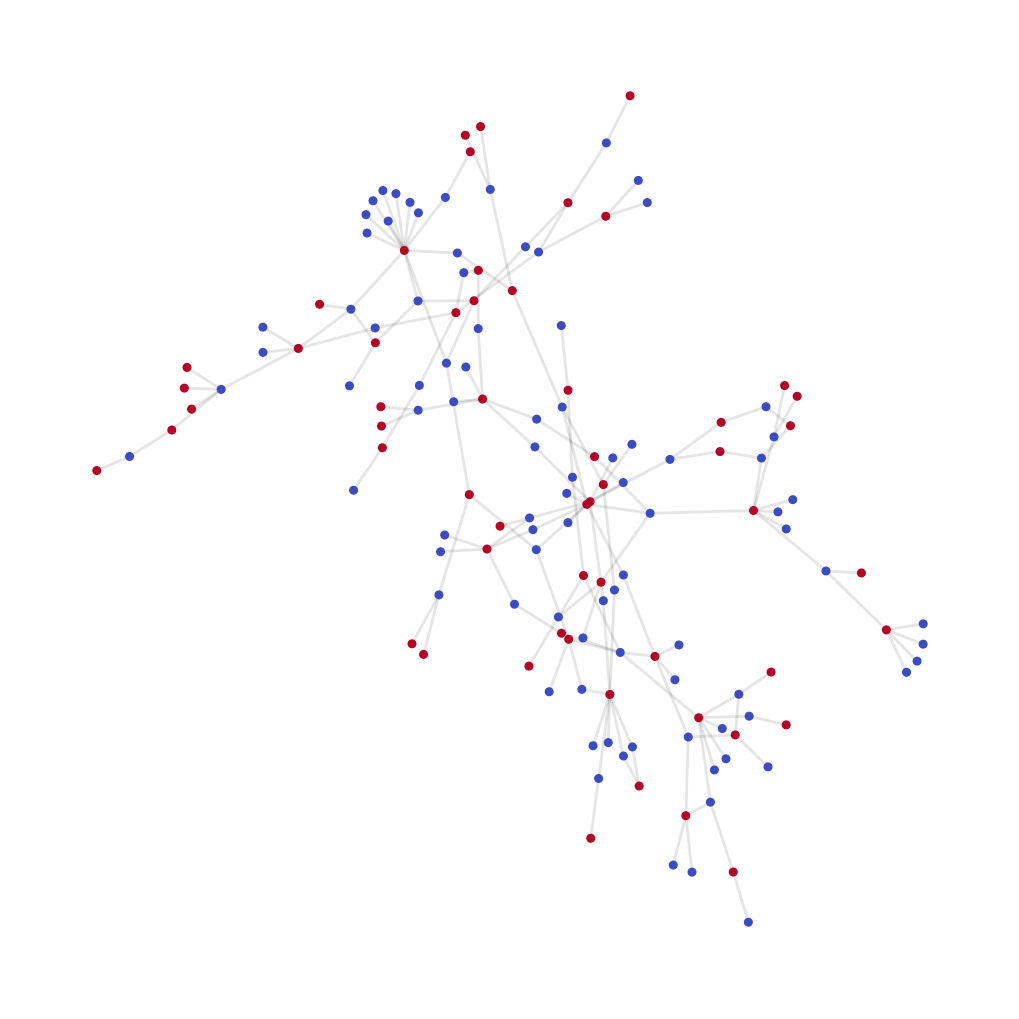

In [12]:
# Graph the subgraph of the small subgraph
color_map = {"playlist": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

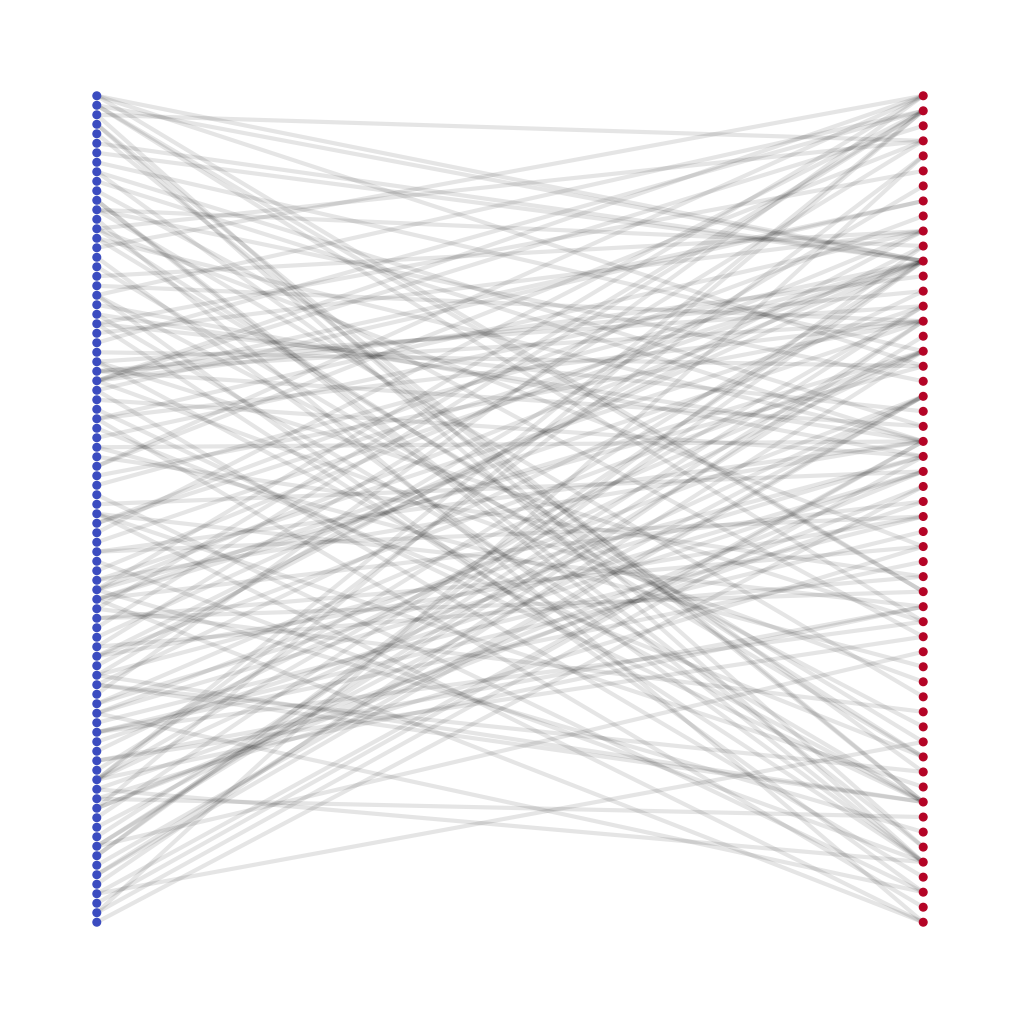

In [13]:
# Show the smaller subgraph as bipartite
top = nx.bipartite.sets(sub_G_sm)[0]
pos = nx.bipartite_layout(sub_G_sm, top)
plt.figure(figsize=(10,10))
nx.draw(sub_G_sm,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))